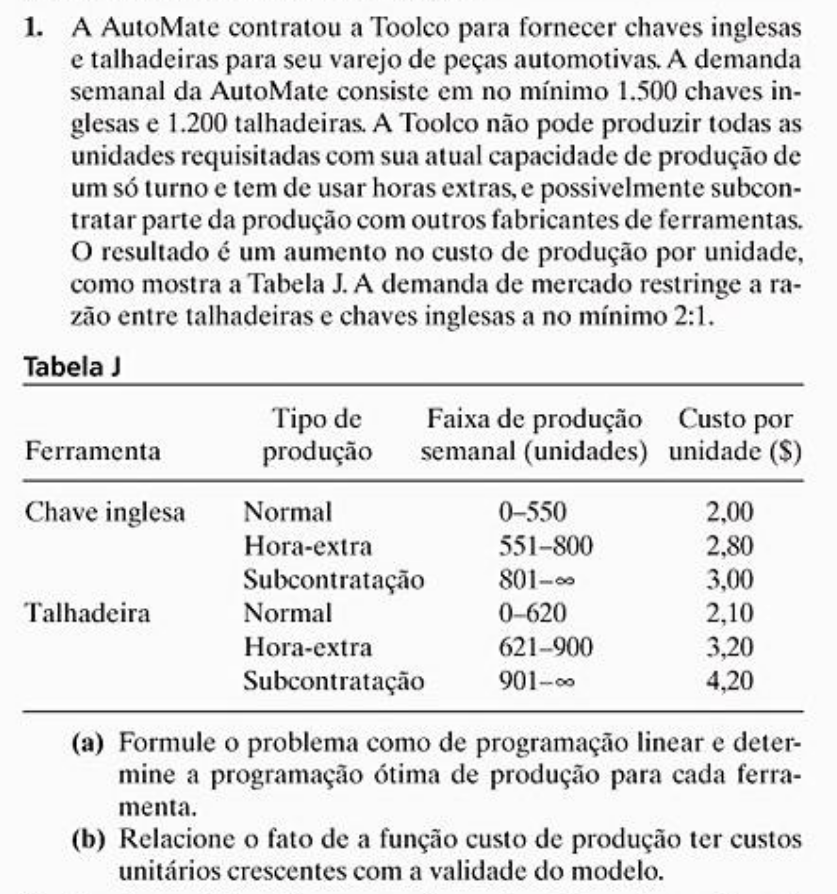

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Otima_Toolco')

In [3]:
# --- Parâmetros extraídos do enunciado e da Tabela J ---

# Ferramentas e tipos de produção
ferramentas = ['chave_inglesa', 'talhadeira']
tipos_producao = ['normal', 'extra', 'sub']

# Demanda mínima semanal
demanda_minima = {'chave_inglesa': 1500, 'talhadeira': 1200}

# Custo por unidade para cada ferramenta em cada tipo de produção
custo_unidade = {
    'chave_inglesa': {'normal': 2.00, 'extra': 2.80, 'sub': 3.00},
    'talhadeira':    {'normal': 2.10, 'extra': 3.20, 'sub': 4.20}
}

# Limites de capacidade para as faixas de produção "Normal" e "Hora-extra"
limite_faixa = {
    'chave_inglesa': {'normal': 550, 'extra': 800 - 550}, # Faixa extra é de 250 unidades
    'talhadeira':    {'normal': 620, 'extra': 900 - 620}  # Faixa extra é de 280 unidades
}

In [4]:
# 1. Variáveis de Decisão
# Quantidade de cada ferramenta a ser produzida em cada faixa de custo
qtd = model.continuous_var_matrix(ferramentas, tipos_producao, name='Qtd')


# 2. Função Objetivo
# Minimizar o custo total de produção
expressao_custo = (custo_unidade[f][t] * qtd[f,t] for f in ferramentas for t in tipos_producao)
custo_total = model.sum(expressao_custo)
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Atender à Demanda Mínima de Cada Ferramenta
for f in ferramentas:
    expressao_total_ferramenta = (qtd[f,t] for t in tipos_producao)
    soma_total_ferramenta = model.sum(expressao_total_ferramenta)
    restr_demanda_logica = soma_total_ferramenta >= demanda_minima[f]
    model.add_constraint(restr_demanda_logica, ctname=f'demanda_{f}')

# Restrição 2: Limites das Faixas de Produção (Capacidade)
for f in ferramentas:
    restr_normal_logica = qtd[f,'normal'] <= limite_faixa[f]['normal']
    model.add_constraint(restr_normal_logica, ctname=f'limite_normal_{f}')

    restr_extra_logica = qtd[f,'extra'] <= limite_faixa[f]['extra']
    model.add_constraint(restr_extra_logica, ctname=f'limite_extra_{f}')
    # A faixa de subcontratação não tem limite superior

# Restrição 3: Razão de Mercado
# Talhadeiras >= 2 * Chaves Inglesas
soma_talhadeiras = model.sum(qtd['talhadeira', t] for t in tipos_producao)
soma_chaves = model.sum(qtd['chave_inglesa', t] for t in tipos_producao)
restr_ratio_logica = soma_talhadeiras >= 2 * soma_chaves
model.add_constraint(restr_ratio_logica, ctname='ratio_mercado')

docplex.mp.LinearConstraint[ratio_mercado](Qtd_talhadeira_normal+Qtd_talhadeira_extra+Qtd_talhadeira_sub,GE,2Qtd_chave_inglesa_normal+2Qtd_chave_inglesa_extra+2Qtd_chave_inglesa_sub)

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA (a) ------\n')
print(solucao)
custo_minimo = custo_total.solution_value
print(f"\nO custo total mínimo da produção é de ${custo_minimo:,.2f}.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 7 rows and 6 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA (a) ------

solution for: Producao_Otima_Toolco
objective: 14918
status: OPTIMAL_SOLUTION(2)
Qtd_chave_inglesa_normal=550.000
Qtd_chave_inglesa_extra=250.000
Qtd_chave_inglesa_sub=700.000
Qtd_talhadeira_normal=620.000
Qtd_talhadeira_extra=280.000
Qtd_talhadeira_sub=2100.000


O custo total mínimo da produção é de $14,918.00.
